In [ ]:
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 26.4 MB/s eta 0:00:00


In [ ]:
!cp /content/drive/MyDrive/lfw.tgz /content
!tar zxvf /content/lfw.tgz

Streaming output truncated to the last 5000 lines.
lfw/Luis_Sanchez/
lfw/Luis_Sanchez/Luis_Sanchez_0001.jpg
lfw/Juliette_Binoche/
lfw/Juliette_Binoche/Juliette_Binoche_0001.jpg
lfw/Joel_Todd/
lfw/Joel_Todd/Joel_Todd_0001.jpg
lfw/Allan_Wagner/
lfw/Allan_Wagner/Allan_Wagner_0001.jpg
lfw/Alejandro_Fernandez/
lfw/Alejandro_Fernandez/Alejandro_Fernandez_0001.jpg
lfw/Guillaume_Depardieu/
lfw/Guillaume_Depardieu/Guillaume_Depardieu_0001.jpg
lfw/Delphine_Chuillot/
lfw/Delphine_Chuillot/Delphine_Chuillot_0001.jpg
lfw/Paul_LeClerc/
lfw/Paul_LeClerc/Paul_LeClerc_0001.jpg
lfw/Eddie_Jordan/
lfw/Eddie_Jordan/Eddie_Jordan_0001.jpg
lfw/Lionel_Richie/
lfw/Lionel_Richie/Lionel_Richie_0001.jpg
lfw/Lionel_Richie/Lionel_Richie_0002.jpg
lfw/Jose_Viegas_Filho/
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0001.jpg
lfw/Jose_Viegas_Filho/Jose_Viegas_Filho_0002.jpg
lfw/Roger_Mahony/
lfw/Roger_Mahony/Roger_Mahony_0001.jpg
lfw/Clay_Aiken/
lfw/Clay_Aiken/Clay_Aiken_0001.jpg
lfw/Clay_Aiken/Clay_Aiken_0002.jpg
lfw/Clay_Ai

In [ ]:
import os
import cv2
from glob import glob
from PIL import Image, ImageDraw

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.utils.tensorboard import SummaryWriter

from torchvision import datasets, transforms

from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training

# Preprocess

In [ ]:
# init parameters
data_dir = '/content/lfw'
dirs = glob(f'{data_dir}/*/*')

print('Number of Persons:', len(os.listdir(data_dir)))
print('Number of images:', len(dirs))

batch_size = 32
epochs = 8
workers = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Number of Persons: 5749
Number of images: 13233


In [ ]:
# detection pretrained model
mtcnn = MTCNN(
    image_size=160,
    margin=0,
    min_face_size=20,
    thresholds=[0.6, 0.7, 0.7],
    factor=0.709,
    post_process=True,
    device=device
)

In [ ]:
# create dataset for cropping faces
dataset = datasets.ImageFolder(data_dir, transform=transforms.Resize((250, 250)))
# change default save directory
dataset.samples = [
    (p, p.replace(data_dir, data_dir + '_cropped'))
        for p, _ in dataset.samples
]

# dataloader       
loader = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    collate_fn=training.collate_pil
)

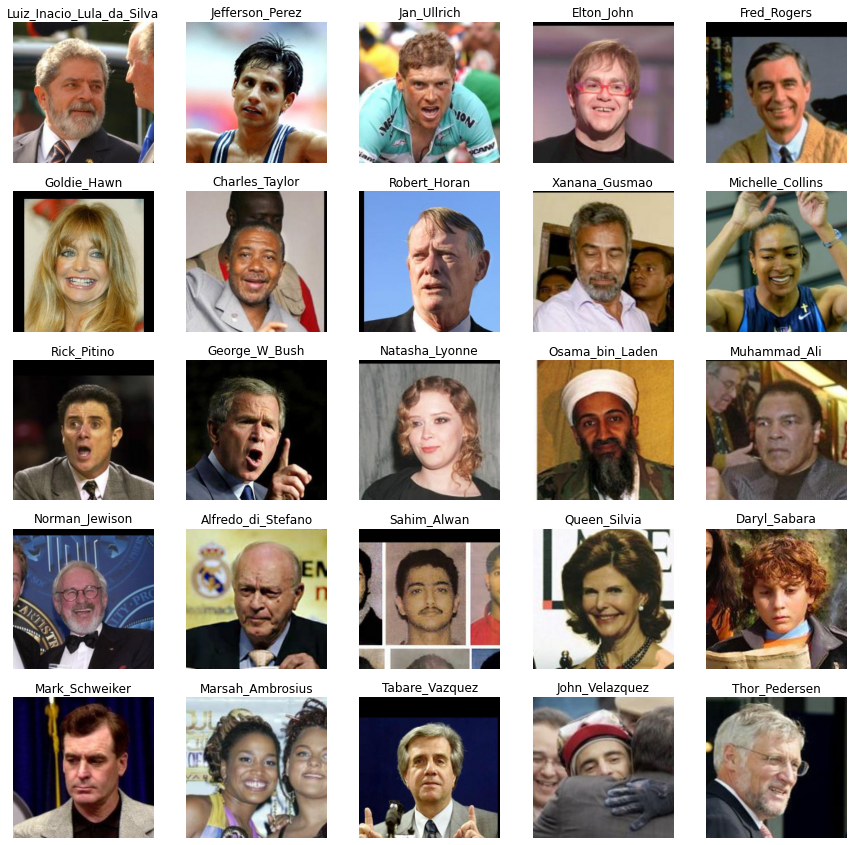

In [ ]:
# plot some random images and names
plt.figure(figsize=(15, 15))
for i in range(25):
    idx = np.random.choice(len(dataset))
    name = dataset[idx][1].split('/')[3]
    plt.subplot(5, 5, i + 1)
    plt.imshow(dataset[idx][0])
    plt.axis('off')
    plt.title(name)

In [ ]:
# crop face from image and save to changed dir
for i, (x, y) in enumerate(loader):
    mtcnn(x, save_path=y)
    print('\rBatch {} of {}'.format(i + 1, len(loader)), end='')
    
# Remove mtcnn to reduce GPU memory usage
del mtcnn

/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  boxes = np.array(boxes)
/usr/local/lib/python3.8/dist-packages/facenet_pytorch/models/mtcnn.py:340: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or nd

Batch 414 of 414

# Train

In [ ]:
# Encoder model
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=len(dataset.class_to_idx)
).to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
# transforms for encoding train
trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

In [ ]:
# create dataset from saved faces
dataset = datasets.ImageFolder(data_dir + '_cropped', transform=trans)

In [ ]:
# create shuffle indexes for split
seed = 1
np.random.seed(seed)
idxs = np.random.permutation(len(dataset))
train_idxs = idxs[:int(0.8 * len(idxs))]
valid_idxs = idxs[int(0.8 * len(idxs)):]

In [ ]:
# create dataloader from dataset and indexes
train_dl = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_idxs)
)
valid_dl = DataLoader(
    dataset,
    num_workers=workers,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(valid_idxs)
)

batch images shape: torch.Size([32, 3, 160, 160])
batch labels shape: torch.Size([32])


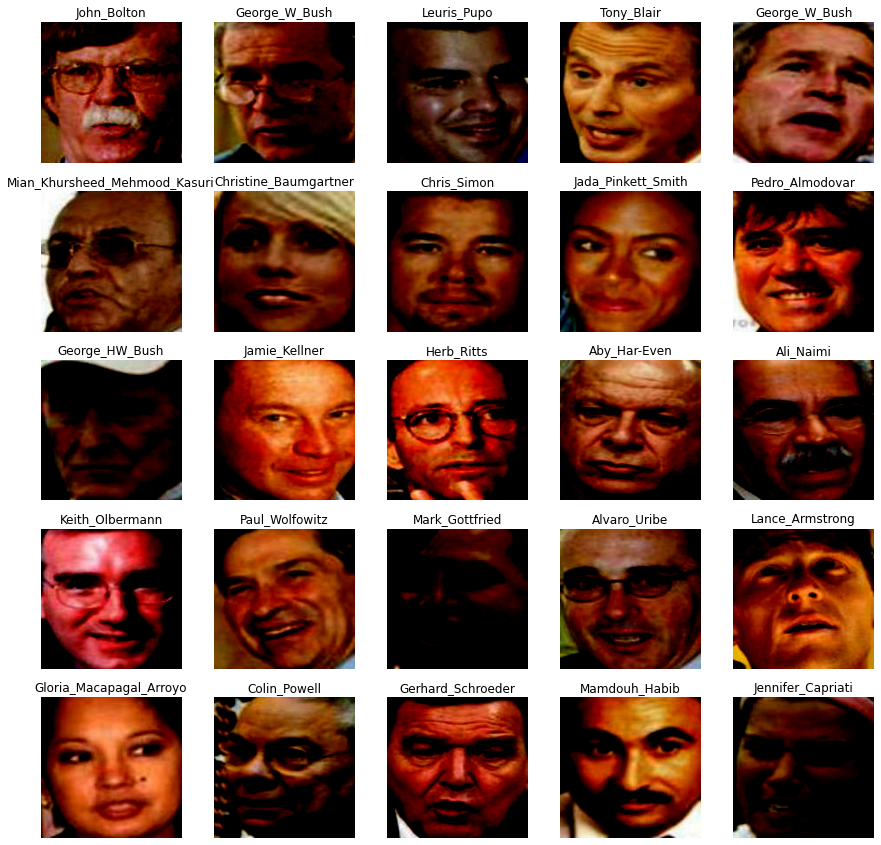

In [ ]:
classes = list(dataset.class_to_idx.keys())
imgs, lbls = next(iter(train_dl))
print('batch images shape:', imgs.shape)
print('batch labels shape:', lbls.shape)
plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(imgs[i].permute(1, 2, 0).clamp(0, 1))
    plt.axis('off')
    plt.title(classes[lbls[i]])

In [ ]:
# initialize training parameters
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])

loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, valid_dl,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_dl, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, valid_dl,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |    83/83   | loss:    8.7954 | fps:  613.2944 | acc:    0.0004   

Epoch 1/8
----------
Train |   331/331  | loss:    7.7871 | fps:  184.9714 | acc:    0.0744   
Valid |    83/83   | loss:    7.4860 | fps:  590.4122 | acc:    0.0843   

Epoch 2/8
----------
Train |   331/331  | loss:    6.6460 | fps:  188.1347 | acc:    0.1284   
Valid |    83/83   | loss:    7.2687 | fps:  601.2132 | acc:    0.1428   

Epoch 3/8
----------
Train |   331/331  | loss:    5.5806 | fps:  188.3317 | acc:    0.1906   
Valid |    83/83   | loss:    7.1820 | fps:  596.6099 | acc:    0.1746   

Epoch 4/8
----------
Train |   331/331  | loss:    4.5775 | fps:  188.2419 | acc:    0.2454   
Valid |    83/83   | loss:    7.0376 | fps:  584.5419 | acc:    0.2204   

Epoch 5/8
----------
Train |   331/331  | loss:    3.5225 | fps:  188.9393 | acc:    0.3228   
Valid |    83/83   | loss:    7.1307 | fps:  606.4684 | acc:    0.2541   

Epoch 6/8
----------
Train |   331/331  | loss:    1.6

In [ ]:
torch.save(resnet, 'lfwResnet.pth')
!cp lfwResnet.pth /content/drive/MyDrive

# Test

In [ ]:
face_size = 160
# an object for detectiong face from image
face_detector = MTCNN(image_size=face_size, margin=0.1)
# face encoder model to convert image to encoding features
face_encoder = InceptionResnetV1(pretrained='vggface2').eval()

In [ ]:
anc_img_dir = '/content/lfw/Aaron_Peirsol/Aaron_Peirsol_0001.jpg'
test_img_dir = '/content/lfw/Aaron_Peirsol/Aaron_Peirsol_0002.jpg'

## Encoding Anchor Face

In [ ]:
# read image from directory
anc_img = Image.open(anc_img_dir)
# detect face from image
anc_res = face_detector.detect(anc_img)
print(anc_res)

(array([[ 82.43525,  70.41288, 167.13661, 184.84915]], dtype=float32), array([0.99992704], dtype=float32))


In [ ]:
# crop face from image and resize to face_size
anc_cropped = face_detector(anc_img, 'anc_face.jpg')
anc_cropped.shape

torch.Size([3, 160, 160])

In [ ]:
# plot image with box and crop image
box, conf = anc_res
x1, y1, x2, y2 = box[0]
conf = conf[0]
draw = ImageDraw.Draw(anc_img)
draw.rectangle([x1, y1, x2, y2], outline = (0, 0, 0), width = 3)

Text(0.5, 1.0, 'Cropped Image with 0.9999270439147949 conf score')

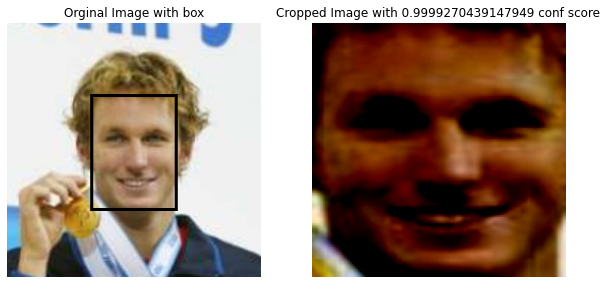

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(anc_img)
plt.axis('off')
plt.title('Orginal Image with box')
plt.subplot(1, 2, 2)
plt.imshow(anc_cropped.permute(1, 2, 0))
plt.axis('off')
plt.title(f'Cropped Image with {conf} conf score')

In [ ]:
# encoding cropped image
face_encoder.classify = True
anc_encoded = face_encoder(anc_cropped.unsqueeze(0)).detach()

## Encoding Test Face and Matching

In [ ]:
# read image from directory
test_img = Image.open(test_img_dir)
# detect face from image
test_res = face_detector.detect(test_img)
print(test_res)

(array([[ 72.80542,  67.04916, 163.383  , 190.85484]], dtype=float32), array([0.9999974], dtype=float32))


In [ ]:
# crop face from image and resize to face_size
test_cropped = face_detector(test_img, 'test_face.jpg')
test_cropped.shape

torch.Size([3, 160, 160])

In [ ]:
# plot image with box and crop image
box, conf = test_res
x1, y1, x2, y2 = box[0]
conf = conf[0]
draw1 = ImageDraw.Draw(test_img)
draw1.rectangle([x1, y1, x2, y2], outline = (0, 0, 0), width = 3)

Text(0.5, 1.0, 'Cropped Image with 0.9999973773956299 conf score')

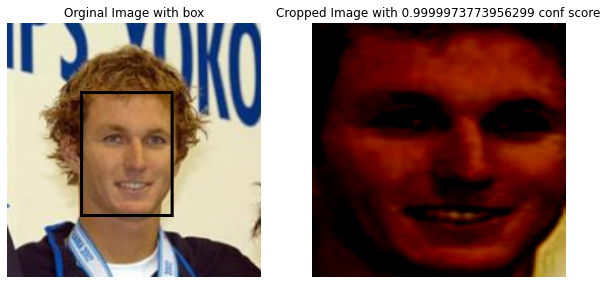

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.axis('off')
plt.title('Orginal Image with box')
plt.subplot(1, 2, 2)
plt.imshow(test_cropped.permute(1, 2, 0))
plt.axis('off')
plt.title(f'Cropped Image with {conf} conf score')

In [ ]:
# encoding cropped image
face_encoder.classify = True
test_encoded = face_encoder(test_cropped.unsqueeze(0)).detach()

In [ ]:
# compare
dist = torch.dist(test_encoded, anc_encoded).item ()
if dist < 230:
    print('Same Person')

else:
    print('Different Person')

Same Person


## Matching function

In [ ]:
def match_images(face_encoder, img_path1, img_path2, conf_tresh=230, save_folder='saved_faces'):
    name1 = os.path.basename(img_path1)
    name2 = os.path.basename(img_path2)

    img1 = Image.open(img_path1)
    img2 = Image.open(img_path2)
    
    img1_cropped = face_detector(img1, save_path=f'{save_folder}/cropped_{name1}')
    img2_cropped = face_detector(img2, save_path=f'{save_folder}/cropped_{name2}')

    face_encoder.classify = True
    encoded1 = face_encoder(img1_cropped.unsqueeze(0)).detach()
    encoded2 = face_encoder(img2_cropped.unsqueeze(0)).detach()

    dist = torch.dist(encoded1, encoded2).item()
    if dist < conf_tresh:
        print(15*' ' + 'Same Person')

    else:
        print(15*' ' + 'Different Person')

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.axis('off')
    plt.show()

In [ ]:
anc_dir = '/content/lfw/Aaron_Peirsol/Aaron_Peirsol_0001.jpg'
same_dir = '/content/lfw/Aaron_Peirsol/Aaron_Peirsol_0003.jpg'
diff_dir = '/content/lfw/Abdulaziz_Kamilov/Abdulaziz_Kamilov_0001.jpg'

               Same Person


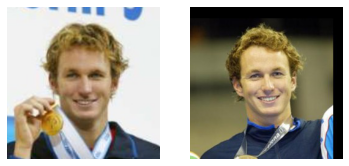

In [ ]:
# default facenet
match_images(face_encoder, anc_dir, same_dir)

               Different Person


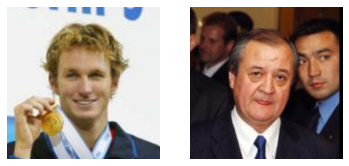

In [ ]:
match_images(face_encoder, anc_dir, diff_dir)

               Same Person


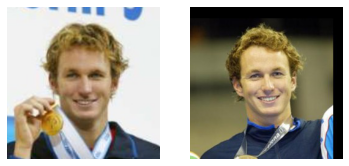

In [ ]:
# trained facenet
match_images(resnet.to('cpu'), anc_dir, same_dir)

               Different Person


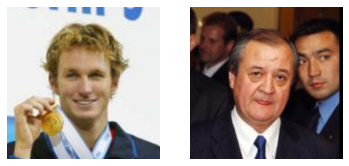

In [ ]:
match_images(resnet.to('cpu'), anc_dir, diff_dir)